# Comparison of the results before and after the adjunction of the enr model production

This notebook compares the carbon emissions of the swiss electricity consumed with and without the improved model using EcoDynElec-EnrModel (as developped by Aymeric Bourdy).
The "with"/"new" model is exactly the same as in the notebook examples/swiss_mix_analysis.

## 0. Configuring EcoDynElec and loading the data

In [1]:
# Autoreload imports
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ecodynelec.parameter import Parameter  # Import the class to manipulate parameters
from examples.mix_analysis.analysis_functions import format_data_0, get_metrics, plot_hourly_heatmap, plot_years, \
    plot_typical_days

In [2]:
# EcoDynElec configuration
my_config = Parameter()
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT']
my_config.target = ['CH']  # You can put multiple targets here
# Enable this if you want to plot fig 6 (will impact the computation time - it took me 15min)
my_config.target = ['CH', 'AT', 'FR', 'DE']
my_config.data_cleaning = True
my_config.sg_imports = True
my_config.path.generation = "../examples/mix_analysis/downloads/generations/"
my_config.path.exchanges = "../examples/mix_analysis/downloads/exchanges/"
# Recommended config: include swiss grid residual (difference between swiss grid and entso-e data)
my_config.residual_global = True

# Years to study
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']
#years = ['2019', '2021']

In [3]:
ordered_countries = ['CH', 'DE', 'FR', 'AT', 'IT', 'Other']
colormap = {
    'sum': 'lightgrey',
    'CH': '#1f77b4',
    'DE': '#c62728',
    'FR': '#2ca02c',
    'IT': '#9467bd',
    'AT': '#ff7f0e',
    'Other': '#e377c2'
}
colormap_extended = colormap | {
    'Nuclear_CH': '#8c564b',
    'Residual_Hydro_Run-of-river_and_poundage_CH': '#000080',  # Couleur bleu marine
    'Residual_Hydro_Water_Reservoir_CH': '#004090',  # Couleur bleu marine
    'Hydro_Water_Reservoir_CH': '#98df8a',
    'Residual_Other_CH': '#ffbb78',
    'Hydro_Pumped_Storage_CH': '#bcbd22',
    'Hydro_Run-of-river_and_poundage_CH': '#17becf',
    'Solar_CH': '#d62728',
    'Other_CH': '#1f77b4'
}
ordered_colors = [colormap[c] for c in ordered_countries]

# change font size
plt.rcParams.update({'font.size': 12})

## 0.1 Load the "new" data

**It's assumed that the data files have already been generated using the swiss_mix_analysis notebook.**

In [4]:
from examples.mix_analysis.analysis_functions import concatenate_and_format_data
from ecodynelec.pipeline_functions import get_producing_mix_kwh, get_consuming_mix_kwh
from examples.mix_analysis.analysis_functions import load_data

# Include real (2020-2022) and estimated (2016-2019) renewable production (using EcoDynElec-Enr-Model)
my_config.ch_enr_model_path = '../support_files/enr_prod_2016-2022_completed.csv'

flows, prods, mixs, prod_impacts, impacts = load_data(my_config.target, my_config.freq, years,
                                                      savedir="../examples/mix_analysis/results_local_all_enr/")

# NOTE: Unless you use multiple targets (see section 0.), these dicts will contain only one element, corresponding to the target country
raw_productions_by_src, raw_consumptions_by_src, electricity_prod_mixs, electricity_mixs, producing_electricity_impacts, electricity_impacts = concatenate_and_format_data(my_config.target, years, flows, prods, mixs, prod_impacts, impacts)

# Extract the data for CH
raw_production_by_src = raw_productions_by_src['CH']
raw_consumption_by_src = raw_consumptions_by_src['CH']
electricity_prod_mix = electricity_prod_mixs['CH']
electricity_mix = electricity_mixs['CH']
electricity_impact = electricity_impacts['CH']
producing_electricity_impact = producing_electricity_impacts[
    'CH']  # pd.DataFrame(producing_electricity_impacts)

## 0.2 Load the "old" data

In [5]:
# Remove the enr model
my_config.ch_enr_model_path = None

#### Case 1: Download and generate data files
This can be done once, then the electrical mix and impact files will be saved and can be loaded directly (see case 2)

In [ ]:
# Data downloading configuration
my_config.server.useServer = False
my_config.server.username = 'your entsoe username'
my_config.server.password = 'your entsoe password'

In [ ]:
from examples.mix_analysis.analysis_functions import generate_data

flows, prods, mixs, prod_impacts, impacts = generate_data(my_config, years,
                                                          savedir="./mix_analysis/results_no_enr_residual/")

#### Case 2: Load data from saved files
If the files for the years of interest have already been generated, they can be loaded directly in this section

In [6]:
from examples.mix_analysis.analysis_functions import load_data

oflows, oprods, omixs, oprod_impacts, oimpacts = load_data(my_config.target, my_config.freq, years,
                                                      savedir="./mix_analysis/results_no_enr_residual/")

# NOTE: Unless you use multiple targets (see section 0.), these dicts will contain only one element, corresponding to the target country
oraw_productions_by_src, oraw_consumptions_by_src, oelectricity_prod_mixs, oelectricity_mixs, oproducing_electricity_impacts, oelectricity_impacts = concatenate_and_format_data(my_config.target, years, oflows, oprods, omixs, oprod_impacts, oimpacts)

# Extract the data for CH
oraw_production_by_src = oraw_productions_by_src['CH']
oraw_consumption_by_src = oraw_consumptions_by_src['CH']
oelectricity_prod_mix = oelectricity_prod_mixs['CH']
oelectricity_mix = oelectricity_mixs['CH']
oelectricity_impact = oelectricity_impacts['CH']
oproducing_electricity_impact = oproducing_electricity_impacts[
    'CH']  # pd.DataFrame(producing_electricity_impacts)

## 1. Compare

Compare the "residual" part decomposition

(0.0, 0.3)

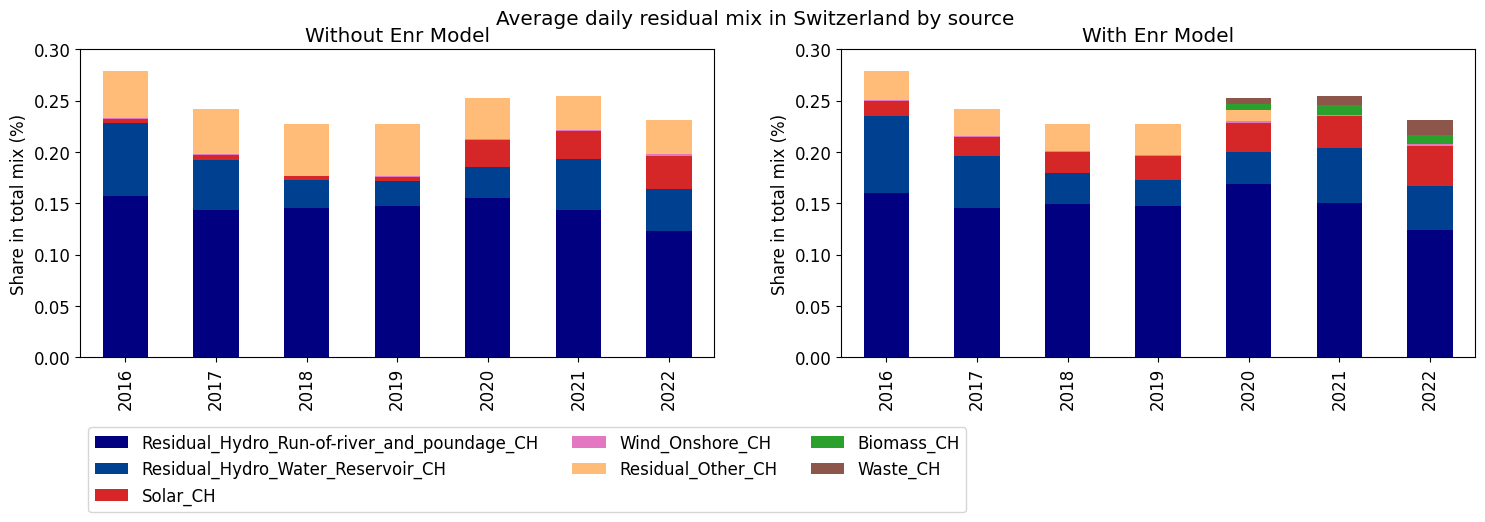

In [17]:
# local CH mix
local_cols = ['Residual_Hydro_Run-of-river_and_poundage_CH', 'Residual_Hydro_Water_Reservoir_CH', 'Solar_CH', 'Wind_Onshore_CH', 'Residual_Other_CH', 'Biomass_CH', 'Waste_CH']
# merged mix
compute_mix = oelectricity_mix['raw_df'][local_cols]#pd.concat([local_mix[local_cols], local_mix['Other_CH']], axis=1)
metric = 'mean'
metric_values = get_metrics(years, compute_mix, [metric], 'Y')

colormap_extended['Wind_Onshore_CH'] = colormap['Other']#'#17becf'
colormap_extended['Biomass_CH'] = colormap['FR']
colormap_extended['Waste_CH'] = colormap_extended['Nuclear_CH']
colors = [colormap_extended[c] for c in compute_mix.columns]

# plot
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
fig.suptitle(f'Average daily residual mix in Switzerland by source')
ax = axs[0]
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, legend=True, color=colors)
ax.set_title(f'Without Enr Model')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 0.3)
# Merge legend of both axes
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=3,
          loc='upper left', bbox_to_anchor=(0, -0.2));

# merged mix
compute_mix = electricity_mix['raw_df'][local_cols]#pd.concat([local_mix[local_cols], local_mix['Other_CH']], axis=1)
metric_values = get_metrics(years, compute_mix, [metric], 'Y')
# plot
ax = axs[1]
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, legend=False, color=colors)
ax.set_title(f'With Enr Model')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 0.3)

Differences of hourly gwp impact

<Axes: >

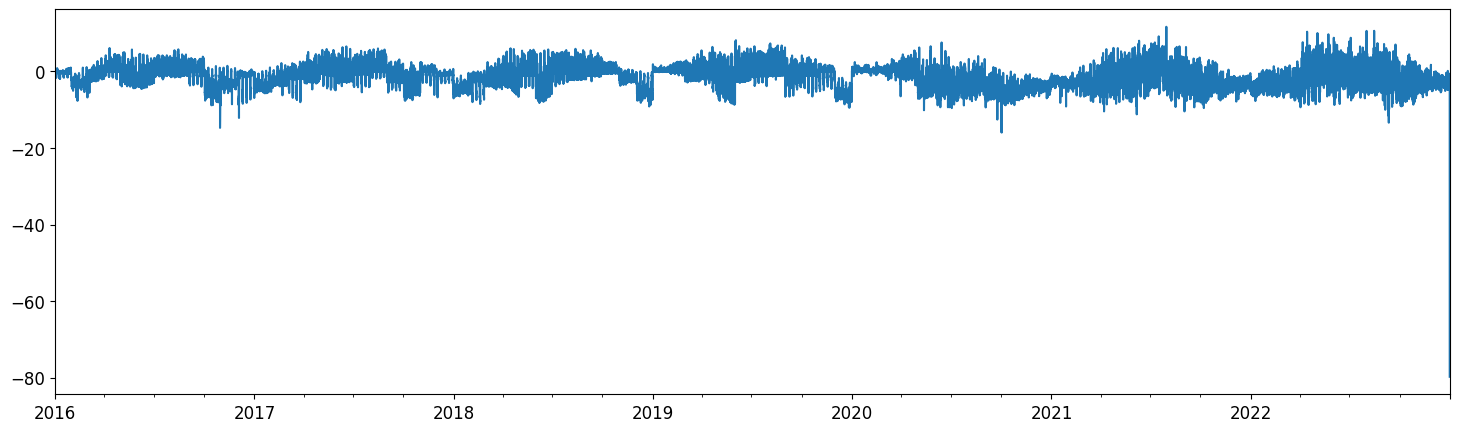

In [9]:
diff = electricity_impact['df']['sum'] - oelectricity_impact['df']['sum']
diff.plot(figsize=(18, 5))

In [10]:
diff.describe()

count    61368.000000
mean        -1.676876
std          2.542921
min        -79.773452
25%         -3.322639
50%         -1.601104
75%         -0.028567
max         11.646959
Name: sum, dtype: float64

Daily-scale differences

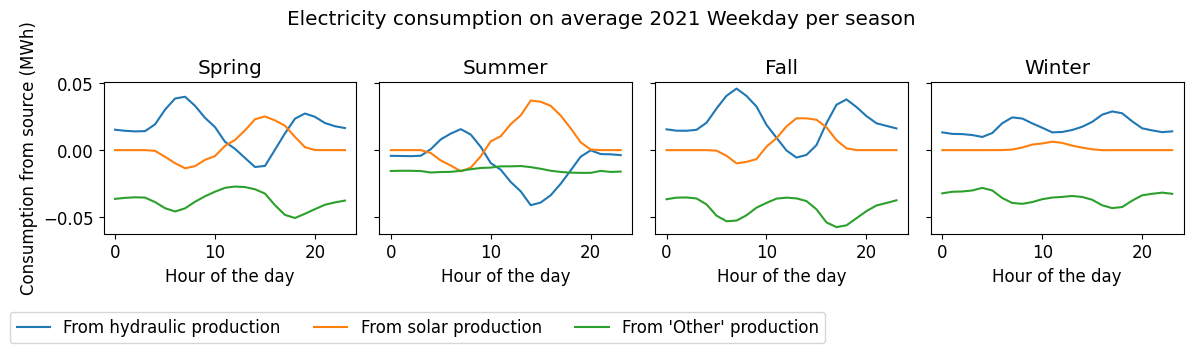

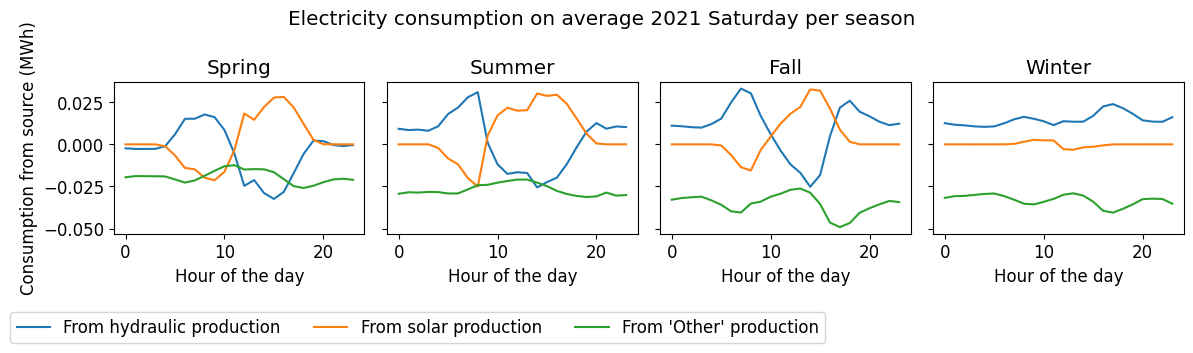

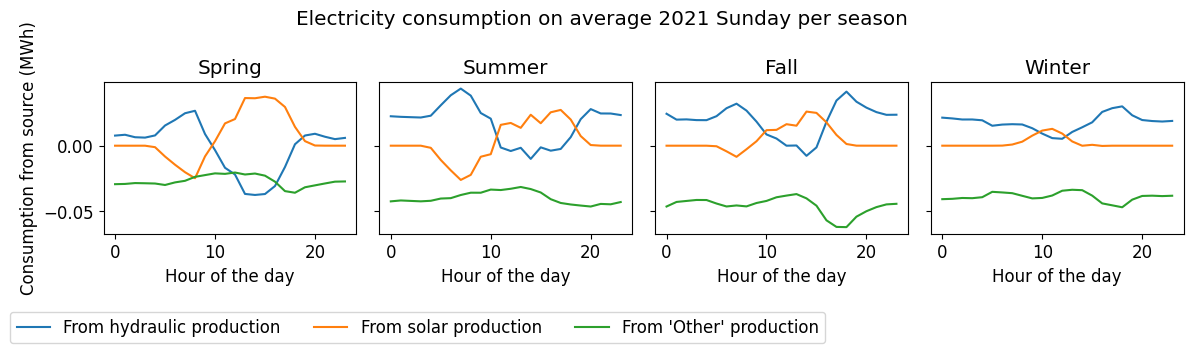

In [12]:
#data = electricity_impact['df'][countries].loc[start:end].copy()
countries = ['hydro', 'solar', 'residual']
start = '2021-01-01'
end = '2021-12-31'
years_label = '2021'
season_names = {2: 'Spring', 3: 'Summer', 4: 'Fall', 1: 'Winter'}

# diff = electricity_mix['df']['sum'] - oelectricity_mix['df']['sum']
# diff_perc = electricity_mix['df']['sum'] * 100 / oelectricity_mix['df']['sum'] - 100
# print('Diff min', diff_perc.loc[start:end].min())
# print('Diff max', diff_perc.loc[start:end].max())
#diff = diff_perc

diff_sol = electricity_mix['raw_df']['Solar_CH'] - oelectricity_mix['raw_df']['Solar_CH']
diff_wind = electricity_mix['raw_df']['Wind_Onshore_CH'] - oelectricity_mix['raw_df']['Wind_Onshore_CH']
diff_hydro = electricity_mix['raw_df']['Hydro_Pumped_Storage_CH'] - oelectricity_mix['raw_df']['Hydro_Pumped_Storage_CH'] + electricity_mix['raw_df']['Hydro_Water_Reservoir_CH'] - oelectricity_mix['raw_df']['Hydro_Water_Reservoir_CH'] + electricity_mix['raw_df']['Hydro_Run-of-river_and_poundage_CH'] - oelectricity_mix['raw_df']['Hydro_Run-of-river_and_poundage_CH'] + electricity_mix['raw_df']['Residual_Hydro_Run-of-river_and_poundage_CH'] - oelectricity_mix['raw_df']['Residual_Hydro_Run-of-river_and_poundage_CH'] + electricity_mix['raw_df']['Residual_Hydro_Water_Reservoir_CH'] - oelectricity_mix['raw_df']['Residual_Hydro_Water_Reservoir_CH']
diff_residual = electricity_mix['raw_df']['Residual_Other_CH'] - oelectricity_mix['raw_df']['Residual_Other_CH']

data = diff_hydro.loc[start:end].copy()
data = pd.DataFrame(data, columns=['hydro'])

data['solar'] = diff_sol.loc[start:end].copy()
#data['wind'] = diff_wind.loc[start:end].copy()
data['residual'] = diff_residual.loc[start:end].copy()

#print(data)
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

season_labels = [*season_names.values()]
weekdays = ['Weekday', 'Saturday', 'Sunday']
for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(len(countries)):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek'] == k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels,
                          f'Electricity consumption on average {years_label} {weekdays[k]}',
                          'Consumption from source (MWh)',
                          fig=fig, ax=ax)
    #for i in range(len(season_labels)):
     #   for j in range(len(ax[i].get_lines())):
      #      ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['From hydraulic production', 'From solar production', 'From \'Other\' production'], loc='upper left', ncol=4,
               bbox_to_anchor=(0, 0))
    plt.show()

Diff min -20.82744949472169
Diff max 18.35662124732353


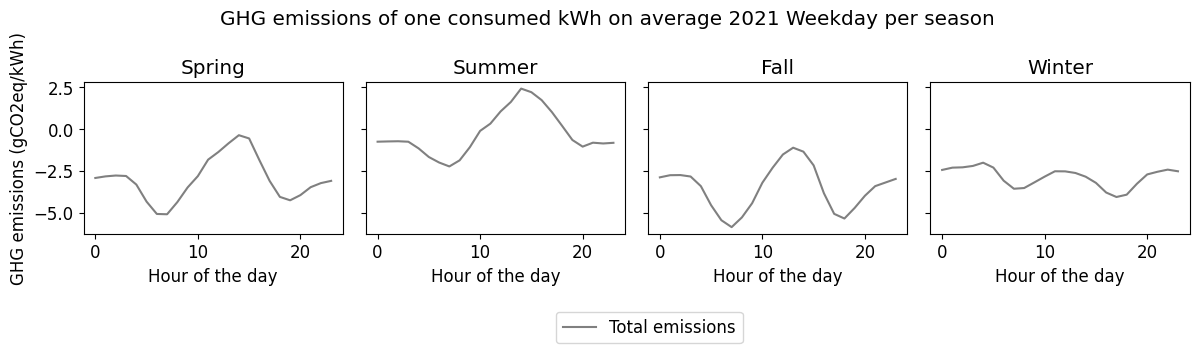

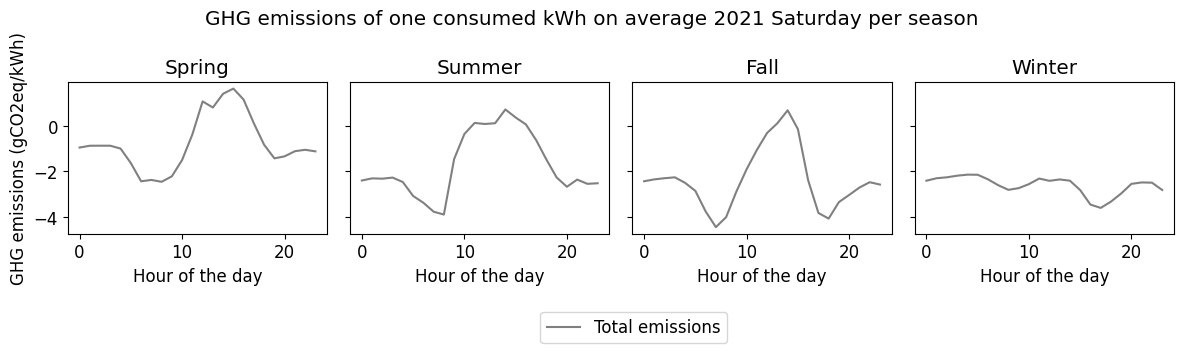

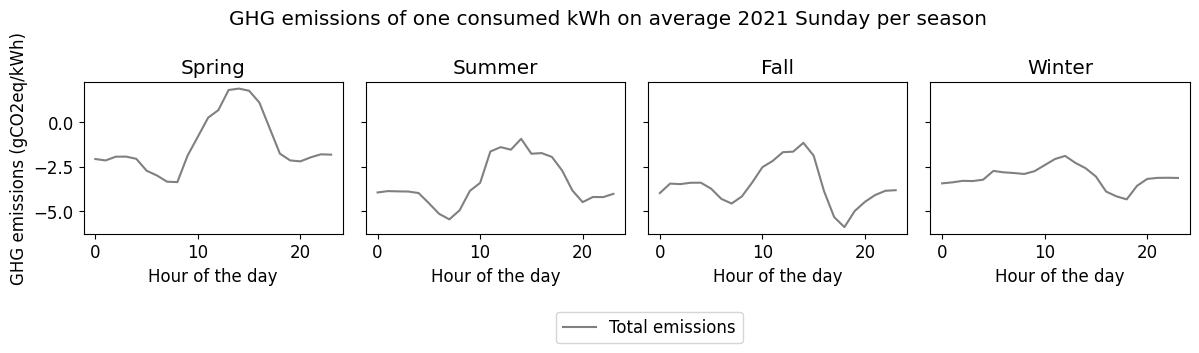

In [14]:
#data = electricity_impact['df'][countries].loc[start:end].copy()
countries = ['sum']#'hydro', 'solar', 'sum', 'residual']
start = '2021-01-01'
end = '2021-12-31'
years_label = '2021'

diff = electricity_impact['df']['sum'] - oelectricity_impact['df']['sum']
diff_perc = electricity_impact['df']['sum'] * 100 / oelectricity_impact['df']['sum'] - 100
print('Diff min', diff_perc.loc[start:end].min())
print('Diff max', diff_perc.loc[start:end].max())
#diff = diff_perc

diff_sol = electricity_impact['raw_df']['Solar_CH'] - oelectricity_impact['raw_df']['Solar_CH']
diff_hydro = electricity_impact['raw_df']['Hydro_Pumped_Storage_CH'] - oelectricity_impact['raw_df']['Hydro_Pumped_Storage_CH'] + electricity_impact['raw_df']['Hydro_Water_Reservoir_CH'] - oelectricity_impact['raw_df']['Hydro_Water_Reservoir_CH'] + electricity_impact['raw_df']['Hydro_Run-of-river_and_poundage_CH'] - oelectricity_impact['raw_df']['Hydro_Run-of-river_and_poundage_CH'] + electricity_impact['raw_df']['Residual_Hydro_Run-of-river_and_poundage_CH'] - oelectricity_impact['raw_df']['Residual_Hydro_Run-of-river_and_poundage_CH'] + electricity_impact['raw_df']['Residual_Hydro_Water_Reservoir_CH'] - oelectricity_impact['raw_df']['Residual_Hydro_Water_Reservoir_CH']
diff_residual = electricity_impact['raw_df']['Residual_Other_CH'] - oelectricity_impact['raw_df']['Residual_Other_CH']

data = diff_hydro.loc[start:end].copy()
data = pd.DataFrame(data, columns=['hydro'])

data['solar'] = diff_sol.loc[start:end].copy()
data['sum'] = diff.loc[start:end].copy()
data['residual'] = diff_residual.loc[start:end].copy()

data = diff.loc[start:end].copy()
data = pd.DataFrame(data, columns=['sum'])

#print(data)
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

season_labels = [*season_names.values()]
weekdays = ['Weekday', 'Saturday', 'Sunday']
for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(len(countries)):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek'] == k][data.columns[i]] for s in seasonal_data]
        #print('data', seasonal_data)
        plot_typical_days(seasonal_data, season_labels,
                          f'GHG emissions of one consumed kWh on average {years_label} {weekdays[k]}',
                          'GHG emissions (gCO2eq/kWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color('gray')
    fig.legend(['Total emissions'], loc='upper left', ncol=4,
               bbox_to_anchor=(0.45, 0))
    plt.show()